# Step 6: Calculate the likelihood ratios given the network outputs

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
plt.style.use("science.mplstyle")

import torch

from numba import cuda 
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


%matplotlib inline


from helpers.likelihood_visualizers import make_c_grid, c_scan_1d, c_scan_2d, c_scan_3d, c_scan_3d_with_confusion
from helpers.test_statistics import get_test_statistic_rate_at_c_points, get_errorbands, get_N_sig_obs_at_c_point
from helpers.bootleg_carl import *
from helpers.utils import np_to_torch, crop_feature
from helpers.plotting import plot_features

In [2]:
# computing

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

seed = 5

Using device: cuda


In [3]:
run_id = "dense_s1_c0_f1"

import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)
    
with open(f"run_configs/{run_id}.yml", "r") as file:
    run_configs = yaml.safe_load(file)

# Data preparation


Load in data

In [4]:
N_train = int(run_configs["bkg.N_train"])
samples_dir = workflow["sampling"]["output_dir"]
identity_code = run_configs["input_precode"]
features = run_configs["features"]
n_features = len(features)
parameter_code = run_configs["parameter_code"]
network_id = run_configs["network_id"]


# load in the samples
samples_SM = np.load(f'{samples_dir}/plain_real/{identity_code}/x_sm.npy')[:,features]
samples_alt = np.load(f'{samples_dir}/plain_real/{identity_code}/x_alt_{parameter_code}.npy')[:,features]
samples_bkg = np.load(f'{samples_dir}/plain_real/delphes_b0/x_bkg.npy')[:,features]
# load in the theta values
theta_alt = np.load(f'{samples_dir}/plain_real/{identity_code}/theta_alt_{parameter_code}.npy')
theta_alt_sm = np.load(f'{samples_dir}/plain_real/{identity_code}/theta_alt_{parameter_code}.npy')

# crop to the number of desired signal events
samples_SM = samples_SM[:N_train]
samples_alt = samples_alt[:N_train]
samples_bkg = samples_bkg[:N_train]
theta_alt = theta_alt[:N_train]
theta_alt_sm = theta_alt_sm[:N_train]


Test sets

In [5]:
if parameter_code == "c0":
    codes = ["m10", "m6", "m4", "p1"]
    targets = [0, -10, -6, -4, 1]
elif (parameter_code == "c1") or (parameter_code == "c2"):
    codes = [ "m2", "p2",]
    targets = [ 0,-2, 2]
    #codes = ["m20", "m16", "m12", "m8", "m4", "p4", "p8", "p12", "p16"]
    #targets = [0, -20, -16, -12, -8, -4, 4, 8, 12, 16]


elif parameter_code == "c0c1":
    if identity_code == "delphes_s":
        codes = ['m10p2p0', 'p3m2p0', 'm4p1p0']
        targets = [[0,0,0],[-1.0, 0.2, 0.0], [0.3, -0.2, 0.0], [-0.4, 0.1, 0.0]]
    elif identity_code == "lhe_s":
        codes = ['m11m5p0', 'm9m2p0', 'p0m7p0', 'm12m13p0', 'm10m12p0', 'p0p5p0', 'p1m11p0', 'm9p9p0', 'm4p4p0', 'p1p2p0']
        targets = [[0,0,0],[-1.1, -0.5, 0.0], [-0.9, -0.2, 0.0], [0.0, -0.7, 0.0], [-1.2, -1.3, 0.0], [-1.0, -1.2, 0.0], [0.0, 0.5, 0.0], [0.1, -1.1, 0.0], [-0.9, 0.9, 0.0], [-0.4, 0.4, 0.0], [0.1, 0.2, 0.0]]

        
elif parameter_code == "c0c2":
    if identity_code == "delphes_s":
        codes = ['m10p0p3', 'p3p0m2', 'm4p0p3']
        targets = [[0,0,0], [-1.0, 0.0, 0.3], [0.3, 0.0, -0.2], [-0.4, 0.0, 0.3]]
    elif identity_code == "lhe_s":
        codes = ['m10p0m13', 'm6p0m14', 'm13p0p3', 'm3p0m13', 'm1p0p6', 'p1p0m3', 'p1p0p7', 'm7p0m3', 'p1p0m6']
        targets = [[0,0,0],[-1.0, 0.0, -1.3], [-0.6, 0.0, -1.4], [-1.3, 0.0, 0.3], [-0.3, 0.0, -1.3], [-0.1, 0.0, 0.6], [0.1, 0.0, -0.3], [0.1, 0.0, 0.7], [-0.7, 0.0, -0.3], [0.1, 0.0, -0.6]]
        
        
elif parameter_code == "c1c2":
    if identity_code == "delphes_s":
        codes = ['p0m2p2', 'p0m3p1', 'p0m1p3']
        targets = [[0,0,0],[0.0, -0.2, 0.2], [0.0, -0.3, 0.1], [0.0, -0.1, 0.3]]
    elif identity_code == "lhe_s":
        codes = ['p0m9m4', 'p0p2p1', 'p0m5m2', 'p0m14m1', 'p0p10m3', 'p0p5m7', 'p0p0m11', 'p0m12p9', 'p0m2m9', 'p0p6p6']
        targets = [[0,0,0],[0.0, -0.9, -0.4], [0.0, 0.2, 0.1], [0.0, -0.5, -0.2], [0.0, -1.4, -0.1], [0.0, 1.0, -0.3], [0.0, 0.5, -0.7], [0.0, 0.0, -1.1], [0.0, -1.2, 0.9], [0.0, -0.2, -0.9], [0.0, 0.6, 0.6]]


test_set_codes = ["sm"]

for c in codes:
    test_set_codes.append(f"alt_{parameter_code}_{c}")

print(test_set_codes)

test_sets = {}

for test_code in test_set_codes:
    test_sets[test_code] = shuffle(np.load(f'{samples_dir}/plain_real/{identity_code}/x_{test_code}_test.npy')[:,features], random_state = 7)

test_sets["bkg"] = shuffle(np.load(f'{samples_dir}/plain_real/delphes_b0/x_bkg_test.npy')[:,features], random_state = 7)

['sm', 'alt_c0_m10', 'alt_c0_m6', 'alt_c0_m4', 'alt_c0_p1']


Preprocess (Standard Scale)

In [6]:
with open(f"models/scaler_{network_id}", "rb") as ifile:
    scaler = pickle.load(ifile)

# transform
samples_SM = scaler.transform(samples_SM)
samples_alt = scaler.transform(samples_alt)
samples_bkg = scaler.transform(samples_bkg)

print(test_set_codes)

for test_code in test_sets.keys():
    test_sets[test_code] = scaler.transform(test_sets[test_code])
    


['sm', 'alt_c0_m10', 'alt_c0_m6', 'alt_c0_m4', 'alt_c0_p1']


Plot hists

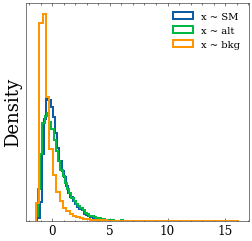

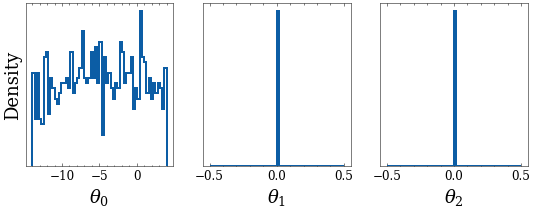

In [7]:

        
nb = 60
bins = [np.linspace(-2, 5, nb) for i in range(n_features)]
axis_labels = ["$m_\mathrm{tot}$", "$p_{T_{aa}}$", "$p_{T_{bb}}$", "$\Delta R_{aa}$", "$\Delta R_{bb}$"]

plot_features([samples_SM, samples_alt, samples_bkg], 
#plot_features([samples_alt, samples_SM, samples_bkg], 
             ["x ~ SM", "x ~ alt", "x ~ bkg"], ["" for i in range(n_features)], nb)



# plot theta
fig, ax = plt.subplots(1, 3, figsize = (3*3, 3))

for i in range(3):
    ax[i].hist(theta_alt[:,i], bins = nb, density = True, histtype = "step", label= "alt", linewidth = 2)
    ax[i].set_xlabel(f"$\\theta_{i}$", fontsize = 18)
    ax[i].set_yticks([])
    
ax[0].set_ylabel("Density", fontsize = 18)
plt.show()


# Evaluation


In [8]:
# load in the networks

seeds = [1, 2, 3, 4, 5]

dense_nets_eval_seeds = {s:{"Ssm_Salt":NeuralNet(n_inputs = n_features + 3, layers = run_configs["network.layers"]), 
                   "B_Salt":NeuralNet(n_inputs = n_features + 3, layers = run_configs["network.layers"]), 
                   "Ssm_B":NeuralNet(n_inputs = n_features, layers = run_configs["network.layers"],), 
                  } for s in seeds}


for key in dense_nets_eval_seeds[1].keys():
    
    for s in seeds:
        if key =="Ssm_B":
            if len(parameter_code) == 2:
                checkpoint = torch.load(f"models/dense_s{s}_c0_f{n_features}_{key}_best_model.pt")
            elif len(parameter_code) == 4:
                checkpoint = torch.load(f"models/dense_s{s}_c0c1_f{n_features}_{key}_best_model.pt")
        else:
            checkpoint = torch.load(f"models/dense_s{s}_{parameter_code}_f{n_features}_{key}_best_model.pt")
        dense_nets_eval_seeds[s][key].load_state_dict(checkpoint["model_state_dict"])
        dense_nets_eval_seeds[s][key].eval().to(device)
    

In [9]:
lower_limits = [-1.4, -0.45, -.6]
upper_limits = [.4, 0.55, 0.5]
N_sig_SM_target = 3600
N_bkg_SM_target = 8160



test code sm at (0, 0, 0) has N_sig 3600.0, sig frac = 0.30612244897959184


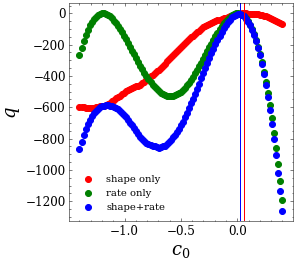

test code alt_c0_m10 at (-10, 0, 0) has N_sig 2331.7597878922693, sig frac = 0.22224677604448906


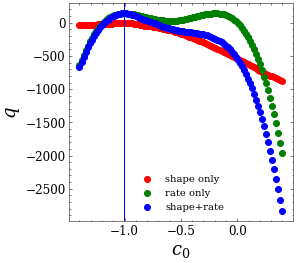

test code alt_c0_m6 at (-6, 0, 0) has N_sig 1277.1373318749158, sig frac = 0.1353310105556323


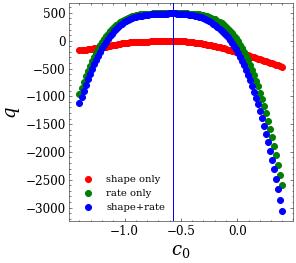

test code alt_c0_m4 at (-4, 0, 0) has N_sig 1530.7853742964612, sig frac = 0.15796298392457114


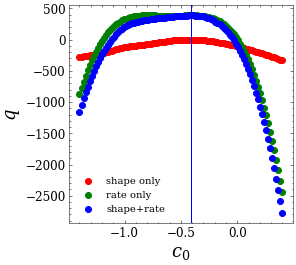

test code alt_c0_p1 at (1, 0, 0) has N_sig 4442.703352438478, sig frac = 0.352519870395812


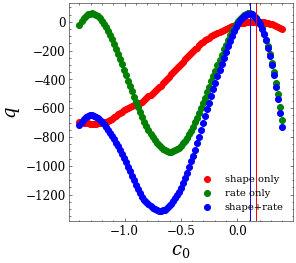

Done


In [10]:
# 1D
    
if len(parameter_code) == 2:
    
    results_dict_rate_only = {}
    results_dict_all = {}
    
    # make the c_grid
    c_grid, c_scans, edges = make_c_grid(101, lower_limits, upper_limits, parameter_code[-1])
    
    for i, test_code in enumerate(test_set_codes[:]):
        
        if parameter_code[-1] == "0":
            loc_c_point = (targets[i],0,0)
        elif parameter_code[-1] == "1":
            loc_c_point = (0,targets[i],0)
        elif parameter_code[-1] == "2":
            loc_c_point = (0,0,targets[i])
                    
        # get the number of signal events that we would expect that c point to have
        loc_N_sig_obs = get_N_sig_obs_at_c_point(workflow["sampling"]["input_dir"], identity_code, loc_c_point, N_sig_SM_target)
        
        # get f_S for the c point
        loc_f_S = loc_N_sig_obs / (N_bkg_SM_target + loc_N_sig_obs)
        
        print(f"test code {test_code} at {loc_c_point} has N_sig {loc_N_sig_obs}, sig frac = {loc_f_S}")
        
        # generate the test set
        
        loc_test_set_sig = test_sets[test_code][:int(loc_N_sig_obs)]
        loc_test_set_bkg = test_sets["bkg"][:int(N_bkg_SM_target)]
        if loc_test_set_sig.shape[0] < int(loc_N_sig_obs):
            print("CAUTION: not enough signal events in test set.")
        if loc_test_set_bkg.shape[0] < N_bkg_SM_target:
            print("CAUTION: not enough background events in test set.")
        loc_test_set = np.vstack([loc_test_set_sig, loc_test_set_bkg])
        
        
        # evaluate the rate-only test statistic for every point in the c_grid
        loc_q_rate, N_sig_c_scan = get_test_statistic_rate_at_c_points(workflow["sampling"]["input_dir"], 
                                                                      identity_code, 10*c_grid, 
                                                                      N_sig_SM_target, N_bkg_SM_target, N_bkg_SM_target + loc_N_sig_obs)

        results_dict_rate_only[test_code] = loc_q_rate
        results_dict_rate_only["cscans"] = c_scans
        

        loc_q_all = c_scan_1d(dense_nets_eval_seeds, device, loc_test_set, N_sig_c_scan, N_sig_SM_target, N_bkg_SM_target, c_grid, c_scans, 
                               parameter_code[-1], [1, 2, 3, 4, 5], q_rate = loc_q_rate)
        results_dict_all[test_code] = loc_q_all
 
    print("Done")


In [11]:

if len(parameter_code) == 2:
    with open(f"preplot_pickles/results_dict_rate_only_{parameter_code}.pkl", "wb") as f:
        pickle.dump(results_dict_rate_only, f)

    with open(f"preplot_pickles/results_dict_all_{parameter_code}_f{n_features}.pkl", "wb") as f:
        pickle.dump(results_dict_all, f)


In [ ]:
# 2D

if len(parameter_code) == 4:
    
    results_dict_rate_only = {}
    results_dict_all = {}

    ttargets = []
    best_fits = []
    
    # make the c_grid
    c_grid, c_scans, edges = make_c_grid(71, lower_limits, upper_limits, parameter_code[1]+parameter_code[3])
    
    for i, test_code in enumerate(test_set_codes[:]):
          
                
        # each test set has a different N_obs, since it was generated by a diff value of c
        loc_N_sig_obs = get_N_sig_obs_at_c_point(workflow["sampling"]["input_dir"], identity_code, [x*10 for x in targets[i]], N_sig_SM_target)
        
        # get f_S for the c point
        loc_f_S = loc_N_sig_obs / (N_bkg_SM_target + loc_N_sig_obs)
        
        print(f"test code {test_code} has N_sig {loc_N_sig_obs}, sig frac = {loc_f_S}", targets[i])
        
        # generate the test set
        loc_test_set_sig = test_sets[test_code][:int(loc_N_sig_obs)]
        loc_test_set_bkg = test_sets["bkg"][:int(N_bkg_SM_target)]
        if loc_test_set_sig.shape[0] < int(loc_N_sig_obs):
            print("CAUTION: not enough signal events in test set.")
        if loc_test_set_bkg.shape[0] < N_bkg_SM_target:
            print("CAUTION: not enough background events in test set.")
        loc_test_set = np.vstack([loc_test_set_sig, loc_test_set_bkg])
        

        # evaluate the rate-only test statistic for every point in the c_grid
        loc_q_rate, N_sig_c_scan = get_test_statistic_rate_at_c_points(workflow["sampling"]["input_dir"], 
                                                                      identity_code, 10*c_grid, 
                                                                      N_sig_SM_target, N_bkg_SM_target, N_bkg_SM_target + loc_N_sig_obs)

        results_dict_rate_only[test_code] = loc_q_rate
        results_dict_rate_only["cscans"] = c_scans
        results_dict_rate_only["cgrid"] = c_grid
        results_dict_rate_only["edges"] = edges

    
        loc_q_all = c_scan_2d(dense_nets_eval_seeds, device, loc_test_set, N_sig_c_scan, N_sig_SM_target, N_bkg_SM_target, c_grid, c_scans, edges,
                                parameter_code[1]+parameter_code[3], [1, 2, 3, 4, 5], q_rate = loc_q_rate, target = targets[i])
        
        results_dict_all[test_code] = loc_q_all
        
        
    
    

    print("Done")


In [ ]:
if len(parameter_code) == 4:
    with open(f"preplot_pickles/results_dict_rate_only_{parameter_code}.pkl", "wb") as f:
        pickle.dump(results_dict_rate_only, f)

    with open(f"preplot_pickles/results_dict_all_{parameter_code}_f{n_features}.pkl", "wb") as f:
        pickle.dump(results_dict_all, f)